In [1]:
import os
from IPython.display import clear_output


notebook_dir = "/home/balabaevvl/nes/ai_economics/sem01"  # notebook's dir
os.chdir(notebook_dir)

GPUs = [
    "GPU-e83bd31b-fcb9-b8de-f617-2d717619413b",
    "GPU-5a9b7750-9f85-49a5-3aae-fe07b1b7661d",
    "GPU-fe2d8dfd-06f2-a5c4-a7fd-4a5f23947005",
    "GPU-0c320096-21ee-4060-8731-826ca2febfab",
    "GPU-baef952c-6609-aace-3b78-e4e07788d5de",
    "GPU-3979d65b-c238-4e9c-0c1c-1aa3f05c56a1",
    "GPU-6c76a2c5-5375-aa06-11d4-0fddfac30e91",
]
os.environ["CUDA_VISIBLE_DEVICES"] = f"{GPUs[2]}"


# Обучение нейросетей: NumPy, PyTorch

Данный ноутбук посвещен изучению функционала и абстракций, которые нам представляет PyTorch для разработки нейронных сетей. Основные моменты, которые будут рассматриваться на данном семинаре:
* Реализация оптимизации градиентным спуском, используя NumPy
* Использование PyTorch Tensors, как замены NumPy ndarrays
* Автоматизация подсчета градиентов при помощи `torch.autograd`
* Использование `torch.nn` для построения вычислительного графа при помощи уже реализованных слоев
* Пакет `torch.optim`, предоставляющий абтракцию оптимизации нейросетей и обновления ее весов
* Использование модулей `Dataset`, `DataLoader` из `torch.utils.data`

In [2]:
!curl -O 'https://courses.cv-gml.ru/storage/seminars/nn-training-numpy-pytorch/test.zip'
!unzip -o test.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2020  100  2020    0     0  17494      0 --:--:-- --:--:-- --:--:-- 17565
Archive:  test.zip
  inflating: test/inp.npy            
  inflating: test/inp_grad.npy       
  inflating: test/out.npy            


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

# Increase these if figures appear small
plt.rcParams["figure.figsize"] = fx, fy = (14.08, 6.40)

In [4]:
def create_random_data(num_samples, num_features, num_targets, seed=42):
    rng = np.random.default_rng(seed)
    feature_locs = rng.normal(size=(1, num_features))
    feature_scales = np.exp(rng.normal(size=(1, num_features)))
    features = rng.normal(
        loc=feature_locs,
        scale=feature_scales,
        size=(num_samples, num_features),
    )

    targets = []
    for _ in range(num_targets):
        num_deps = 1 + rng.integers(num_features)
        dep_inds = rng.choice(num_features, num_deps)
        deps = features[:, dep_inds]

        offsets = rng.uniform(0, 2 * np.pi, size=num_deps)
        scales = rng.normal(size=num_deps)

        target = scales[None, :] * np.sin(deps + offsets[None, :])
        targets.append(target.sum(axis=-1))

    targets = np.stack(targets, axis=-1)
    return features, targets

In [5]:
def visualize_results():
    # Show training loss history
    plt.subplot(1, 2, 1)
    plt.title("Training loss history")
    plt.plot(loss_hist)
    plt.yscale("log")
    plt.xlabel("step")
    plt.ylabel("loss")

    # Visualize ground truth vs predictions
    plt.subplot(1, 2, 2)
    plt.title("Ground truth vs predictions")
    for i in range(D_out):
        plt.scatter(y_vis[:, i], p_vis[:, i], s=1)
    plt.xlabel("y")
    plt.ylabel("p")

    plt.show()

## Разминка на NumPy

Перед тем, как переходить к рассмотрению PyTorch, давайте сначала реализуем логику для запуска и оптимизации градиентным спуском простой нейросети с помощью NumPy.

NumPy - это framework для научных вычислений; он ничего не знает о вычислительных графах, глубоком обучении или градиентах. Однако мы можем легко использовать NumPy для обучения простой двухслойной нейросети на случайных данных вручную, реализуя прямые и обратные проходы через сеть с помощью NumPy.

In [6]:
# N is number of samples; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 100, 16, 100, 4

In [7]:
# Create random input and output data
x, y = create_random_data(N, D_in, D_out)

In [8]:
# Randomly initialize weights
scale1 = 1 / np.sqrt(D_in)
scale2 = 1 / np.sqrt(H)
w1 = np.random.uniform(-scale1, scale1, size=(D_in, H))
w2 = np.random.uniform(-scale2, scale2, size=(H, D_out))


In [9]:
((x @ w1).clip(0, None) @ w2).shape

(100, 4)

In [10]:
# Hyperparameters for the train loop
learning_rate = 1e-4
num_steps = 50_000


$$
\frac{\partial \mathcal{L}}{\partial W^{2}}
=
\Big(\frac{\partial h_2}{\partial W^{2}}\Big)^{\!\top}
\frac{\partial \mathcal{L}}{\partial h_2}
=
a_1^{\top}(h_2-y),
\quad
\frac{\partial \mathcal{L}}{\partial h_2}
=
\frac{\partial}{\partial h_2}\Big(\tfrac{1}{2}\|h_2-y\|_F^2\Big)
=
h_2 - y
$$


$$
\frac{\partial \mathcal{L}}{\partial W^{1}}
=
\Big(\frac{\partial h_1}{\partial W^{1}}\Big)^{\!\top}\frac{\partial \mathcal{L}}{\partial h_1}
=
\Big(\frac{\partial h_1}{\partial W^{1}}\Big)^{\!\top}
\Bigg[
\frac{\partial \mathcal{L}}{\partial a_1}
\ \odot\
\frac{\partial a_1}{\partial h_1}
\Bigg]
$$

$$
=
\Big(\frac{\partial h_1}{\partial W^{1}}\Big)^{\!\top}
\Bigg[
    \frac{\partial \mathcal{L}}{\partial h_2}
\Big(\frac{\partial h_2}{\partial a_1}\Big)^{\!\top}
\ \odot\
\frac{\partial a_1}{\partial h_1}
\Bigg]
=
x^{\top}\Big(((h_2-y)(W^{2})^{\top})\odot(h_1> 0)\Big)
$$


In [14]:
loss_hist = []
progress = tqdm(range(num_steps))

for t in progress:
    h_1 = x @ w1                # [N, D_in] @ [D_in, H] -> [N, H]
    a_1 = h_1.clip(0, None)     # [N, H]
    h_2 = a_1 @ w2              # [N, H] @ [H, D_out] -> [N, D_out]

    loss = (1 / 2) * ((h_2 - y) ** 2).sum() / N

    # Save the loss value to history and display it in the progress bar
    loss_hist.append(loss)
    progress.desc = f"loss: {loss:.8f}"

    # Backprop to compute gradients of w1 and w2 with respect to loss
    delta = (h_2 - y) / N                           # [N, D_out]
    grad_w2 = a_1.T @ delta                         # [H, N] @ [N, D_out] = [H, D_out] - same as w2
    grad_w1 = x.T @ ((delta @ w2.T) * (h_1 >= 0))   # [D_in, N] ([N, D_out] @ [D_out, H]) * [N, H] = [D_in, H] - same as w1

    # Update weights
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2


  0%|          | 0/50000 [00:00<?, ?it/s]

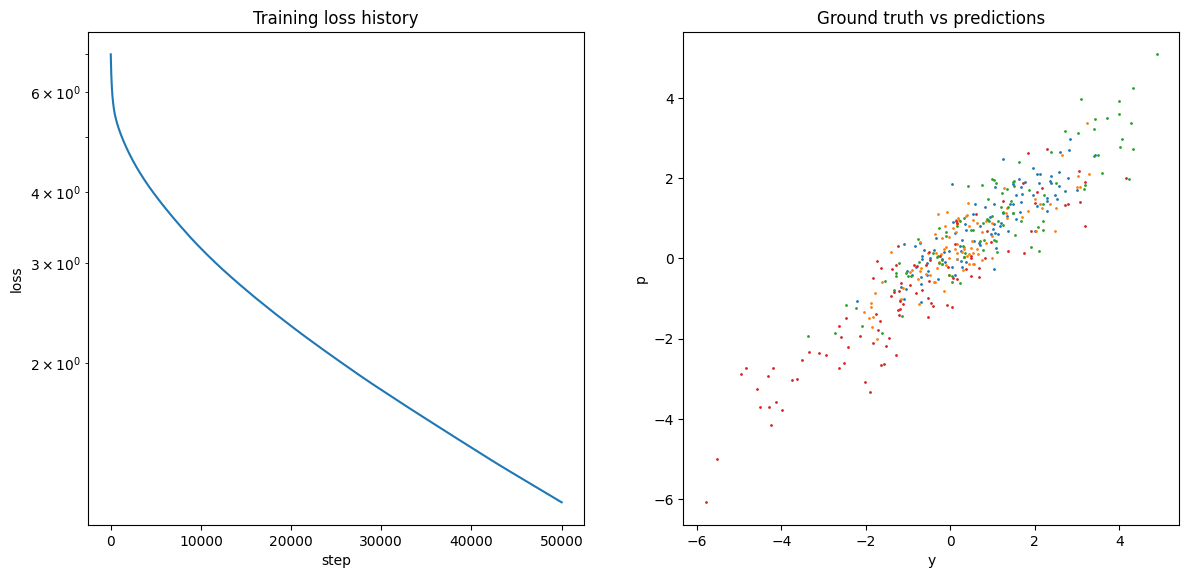

In [12]:
# Implement inference/prediction
p = (x @ w1).clip(0, None) @ w2

p_vis = p
y_vis = y
visualize_results()

## PyTorch Tensors

NumPy - отличный фреймворк, но он не может использовать GPU для ускорения численных вычислений. Для современных нейронных сетей графические процессоры часто обеспечивают ускорение в 50 раз или больше, поэтому использование NumPy не достаточно для реализации современных методов глубинного обучения.

Здесь мы представляем самую фундаментальную концепцию PyTorch - тензоры. Тензоры в PyTorch - концептуально идентичны N-мерным массивам NumPy. PyTorch предоставляет множество функций для работы с этими тензорами. Любые вычисления, которые вы, возможно, захотите выполнить с помощью NumPy, также могут быть выполнены с помощью тензоров PyTorch. Многие (**но не все**) функции и методы для работы с тензорами имеют те же имена и интерфейсы как в NumPy.

В отличие от N-мерных массивов NumPy, тензоры PyTorch могут использовать GPU для ускорения численных вычислений. Чтобы создать тензор на GPU, можно передать соответствующий аргумент `device` при создании этого тензора. Уже существующий тензор можно скопировать на нужный девайс, используя методы `tensor.to(device)`, `tensor.cpu()` или `tensor.cuda()`.

Для конвертации между существующими N-мерными NumPy массивами и PyTorch тензорами, можно использовать функцию `torch.from_numpy(ndarray)` и метод `tensor.numpy()`. Обратите внимание, что для конвертации PyTorch тензора в NumPy массив необходимо, чтобы этот тензор находился на CPU.

В данном разделе мы используем тензоры PyTorch, чтобы обучить нейросеть на случайных данных. Как и в приведенном выше примере на NumPy, давайте вручную реализуем прямой и обратный проходы по сети, используя операции с тензорами PyTorch.

In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using the GPU 😊")
else:
    device = torch.device("cpu")
    print("Using the CPU 😞")

In [14]:
x, y = create_random_data(N, D_in, D_out)

# Load input and output data onto the device
x = torch.from_numpy(x).to(dtype=torch.float32, device=device)
y = torch.from_numpy(y).to(dtype=torch.float32, device=device)

In [15]:
# Randomly initialize weights
w1 = torch.empty((D_in, H), device=device)
w2 = torch.empty((H, D_out), device=device)
w1.uniform_(-scale1, scale1)
w2.uniform_(-scale2, scale2);

In [ ]:
loss_hist = []
progress = tqdm(range(num_steps))

for t in progress:
    h_1 = x @ w1                        # [N, D_in] @ [D_in, H] -> [N, H]
    a_1 = h_1.clip(0, None)             # [N, H]
    h_2 = a_1 @ w2                      # [N, H] @ [H, D_out] -> [N, D_out]

    loss = (1 / 2) * ((h_2 - y) ** 2).sum() / N

    # Save the loss value to history and display it in the progress bar
    loss_hist.append(loss.item())
    progress.desc = f"loss: {loss:.8f}"

    # Backprop to compute gradients of w1 and w2 with respect to loss
    delta = (h_2 - y) / N               # [N, D_out]
    
    rest = delta                        # [N, D_out]
    grad_w2 = a_1.T @ rest              # [H, N] @ [N, D_out] = [H, D_out] - same as w2
    
    rest = (delta @ w2.T) * (h_1 >= 0)   # [N, D_out] @ [D_out, H]) * [N, H] = [N, H]
    grad_w1 = x.T @ rest                # [D_in, N] @ [N, H] = [D_in, H] - same as w1

    # Update weights
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2


In [17]:
# Implement inference/prediction
p = (x @ w1).clip(0, None) @ w2

p_vis = p.cpu().numpy()
y_vis = y.cpu().numpy()
visualize_results()

## PyTorch `autograd`

В примере выше нами был реализован, как прямой проход по сети, так и обратное распространение ошибки. Реализовывать каждый раз обратное распространение ошибки неэффективно и громоздко, ведь как мы знаем современные нейросетевые архитектуры могут состоять из сотен слоев и содержать тысячи операций в самых разных нетривиальных конфигурациях.

Для этого в PyTorch реализована поддержка [автоматического дифференциирования в обратном режиме](https://en.wikipedia.org/wiki/Automatic_differentiation) (aka backprop). При использовании `torch.autograd`, выполнение прямого прохода вашей сети будет автоматически сохранять необходимые промежуточные результаты и записывать граф вычислительных зависимостей. Узлы в этом графе будут тензорами, а ребра - функциями, которые производят выходные тензоры из входных тензоров. Обратное распространение ошибки через этот граф затем позволяет легко вычислять градиенты.

На практике использование данной технологии весьма простое: если мы хотим вычислить градиенты относительно некоторого тензора, тогда мы устанавливаем атрибут `requires_grad = True` при создании этого тензора или вызвав метод `tensor.requires_grad_()`. Любые дифференциируемые операции PyTorch с этим тензором будут автоматически возвращать тензоры, которые будут "помнить" свой вычислительный граф, что позволит нам позже выполнить обратное распространение ошибки через них. Если `x` - тензор с `requires_grad = True`, то после обратного распространения ошибки, `x.grad` будет другим тензором, содержащим градиент `x` относительно некоторого скалярного значения.

Если нам наоборот не хочется сторить граф для выполнения обратного распространения ошибки через тензор с установленным атрибутом `requires_grad = True` (например, когда мы обновляем веса модели), то мы можем использовать контекстный менеджер `torch.no_grad()`, чтобы избежать построения вычислительного графа. В ситуации, когда у нас уже есть тензор `x`, являющийся частью графа, то можно получить копию данных этого тензора "отщепленную" от графа зависимостей выполнив операцию `x.detach()`.

Ниже мы реализуем обучние нейронной сети с использованием автоматического подсчета градиентов `autograd`.

In [18]:
# Create random Tensors for weights; setting requires_grad=True means that we
# want to compute gradients for these Tensors during the backward pass.
w1 = torch.empty((D_in, H), device=device, requires_grad=True)
w2 = torch.empty((H, D_out), device=device, requires_grad=True)
with torch.no_grad():
    w1.uniform_(-scale1, scale1)
    w2.uniform_(-scale2, scale2)

loss_hist = []
progress = tqdm(range(num_steps))
for t in progress:
    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.
    p = (x @ w1).clamp_min(0) @ w2
    # p = (x @ w1).relu() @ w2

    # Compute the loss. Loss must be a scalar tensor
    loss = (1 / 2) * ((p - y) ** 2).sum() / N

    # Save the loss value to history and display it in the progress bar
    # CAUTION! Don't forget that the loss tensor lives on the device
    # and keeps a reference to the whole computation graph!
    # Save the loss value to history and display it in the progress bar
    loss_hist.append(loss.item())
    progress.desc = f"loss: {loss:.8f}"

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.
    loss.backward()

    # Update weights using gradient descent. For this step we just want to mutate
    # the values of w1 and w2 in-place; we don't want to build up a computational
    # graph for the update steps, so we use the torch.no_grad() context manager
    # to prevent PyTorch from building a computational graph for the updates.
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

    # CAUTION! Autograd loss.backward() ACCUMULATES the gradients, it effectively
    # does `w.grad += ...` for each tensor with requires_grad=True in the graph.
    # You need to manually clear the gradients between backward passes!
    # Options:
    # w1.grad *= 0
    # w2.grad *= 0
    # ---
    # w1.grad[:] = 0
    # w2.grad[:] = 0
    # ---
    # w1.grad.zero_()
    # w2.grad.zero_()
    # Best:
    w1.grad = None
    w2.grad = None

In [19]:
# Don't forget to wrap the forward computation in torch.no_grad()!
with torch.no_grad():
    p = (x @ w1).relu() @ w2

p_vis = p.cpu().numpy()
y_vis = y.cpu().numpy()
visualize_results()

## Custom PyTorch `autograd` Functions

Под капотом каждый примитивный оператор `autograd` - это на самом деле две функции, которые работают с тензорами. Функция `forward` вычисляет выходные тензоры из входных тензоров. Функция `backward` получает градиент выходных тензоров относительно некоторого скалярного значения и вычисляет градиент входных тензоров относительно того же скалярного значения.

В PyTorch мы можем легко определить наш собственный оператор `autograd`, определив подкласс `torch.autograd.Function` и реализовав на нем статические функции `forward` и `backward`. Затем мы можем использовать наш новый оператор, вызвая функцию `.apply` на этом подкласее, передавая в неё произвольные аргументы, которые будут затем переданы в наш метод `forward`.

В этом примере мы определяем нашу собственную `autograd` функцию для выполнения нелинейности `ReLU` и используем ее в реализации нашей сети:

In [21]:
class MyReLU(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, x):
        """
        In the forward pass we receive a context object and one or more input
        Tensors; we must return a single Tensor (or a tuple of Tensors)
        containing the output(s). We can use the context object to cache
        tensors and arbitrary python objects for use in the backward pass.
        """
        # ctx.save_for_backward(x)
        mask = x >= 0
        ctx.save_for_backward(mask)
        
        output = x.clamp_min(0)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive the context object and Tensors containing
        the gradient of the loss with respect to each of the outputs produced during
        the forward pass. We can retrieve cached data from the context object, and
        must compute and return the gradient of the loss with respect to the inputs
        originally passed to the forward function (or None, if no gradient wrt that
        input exists).
        """
        # x, = ctx.saved_tensors
        # mask = x >= 0        
        mask, = ctx.saved_tensors

        grad_x = mask * grad_output
        return grad_x

In [23]:
w1 = torch.empty((D_in, H), device=device, requires_grad=True)
w2 = torch.empty((H, D_out), device=device, requires_grad=True)
with torch.no_grad():
    w1.uniform_(-scale1, scale1)
    w2.uniform_(-scale2, scale2)

loss_hist = []
progress = tqdm(range(num_steps))
for t in progress:
    p = MyReLU.apply(x @ w1) @ w2

    loss = (1 / 2) * ((p - y) ** 2).sum() / N

    loss_hist.append(loss.item())
    progress.desc = f"loss: {loss:.8f}"

    loss.backward()

    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

    w1.grad = None
    w2.grad = None


In [24]:
# Don't forget to wrap the forward computation in torch.no_grad()!
with torch.no_grad():
    p = MyReLU.apply(x @ w1) @ w2

p_vis = p.cpu().numpy()
y_vis = y.cpu().numpy()
visualize_results()

Чтобы ближе ознакомиться с `autograd` вам предлагаемся самим написать функцию активации `SoftPlus`: $\log(1 + \exp(x))$.



![](https://courses.cv-gml.ru/storage/seminars/nn-training-numpy-pytorch/activation-softplus.png)

Подсказка
Производная `SoftPlus` имеет вид: $\frac{\exp(x)}{1 + \exp(x)}$

In [31]:
class SoftPlus(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):

        exp = torch.exp(x)          # can result in `torch.inf` for large x
        mask = exp > 1e6
        output = torch.log1p(exp)   # more numerically stable than `torch.log(1 + exp)`
        output[mask] = x[mask]

        ctx.save_for_backward(exp, mask)

        return output

    @staticmethod
    def backward(ctx, grad_output):
        exp, mask = ctx.saved_tensors

        partial = exp / (1 + exp)
        partial[mask] = 1
        grad_x = partial * grad_output
        return grad_x

Протестируйте `SoftPlus`:

In [32]:
inp_test = torch.from_numpy(np.load("test/inp.npy")).to(device)
inp_test.requires_grad = True

out_pred = SoftPlus.apply(inp_test)
loss = out_pred.sum()
loss.backward()

out_test = np.load("test/out.npy")
inp_grad_test = np.load("test/inp_grad.npy")
assert np.allclose(
    out_pred.detach().cpu().numpy(), out_test
), "Most likely, the forward pass implementation is incorrect"
assert np.allclose(
    inp_test.grad.cpu().numpy(), inp_grad_test
), "Most likely, the backward pass implementation is incorrect"

Попробуйем обучить что-нибудь с ипользованием данной функции

In [ ]:
# Copy-paste and edit the train loop from previous section
+...

# Use SoftPlus in the forward computation instead

In [ ]:
# Copy-paste the inference code from previous section
+...

# Use SoftPlus in the forward computation instead

## PyTorch `nn`

Построение вычислительного графа и `autograd` уже являются очень мощными инструментами для разработки моделей глубокого обучения, но тем не менее для полноценной работы с нейронными сетями являются слишком низкоуровневыми.

В PyTorch реализован еще один уровень абстракции в виде пакета `nn`, который позволяет не задумываться про написание `autograd` функций, а использовать уже готовые, с написанными `forward` и `backward` функциями.

Пакет `nn` определяет набор модулей, которые примерно эквивалентны слоям нейронной сети. Модуль получает входные тензоры и вычисляет выходные тензоры, но также может хранить внутреннее состояние, например, тензоры, содержащие обучаемые параметры. Пакет `nn` также определяет набор полезных функций потерь, которые обычно используются при обучении нейронных сетей.

In [ ]:
# Use the nn package to define our model as a sequence of layers.
# nn.Sequential is a Module which contains other Modules, and applies
# them in sequence to produce its output. nn.Linear is a Module that
# computes applies a linear function and holds internal Tensors
# for its weights biases. After constructing the model we use the
# .to() method to move it (and all of its constituent parameters)
# to the desired device.
#
# Note: Disable the bias in Linear layers here for consistency
# with previous simplified, manually implemented examples.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H, bias=False),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out, bias=False),
).to(device)

# The nn package also contains definitions of popular loss functions;
# in this case we will use Mean Squared Error (MSE) as our loss function.
#
# Note: Pass reduction="sum" in order to compute the *sum* of squared
# errors rather than the mean; this is for consistency with the previous
# simplified examples. In practice it is more common to use mean squared
# error as a loss by using reduction="mean" (which is the default).
loss_fn = torch.nn.MSELoss(reduction="mean").to(device)

# Switch model into training mode
model = model.train()

# Copy-paste and edit the train loop from previous section
loss_hist = []
progress = tqdm(range(num_steps))
for t in progress:
    # Forward pass and Loss computation:
    # - Module objects override the __call__
    #     operator so you can call them like functions.
    # - The torch.nn.*Loss functions are also just modules that
    #     take two arguments - predicted values and ground truth.
    p = model(x)
    loss = loss_fn(p, y)

    loss_ = loss.detach().item()
    loss_hist.append(loss_)
    progress.desc = f"loss: {loss_:.8f}"
    loss.backward()

    # Iterate over all model parameters and update them.
    with torch.no_grad():
        for param in model.parameters():
            param.data -= learning_rate * param.grad

    # Zero the gradients for all parameters in the model.
    model.zero_grad()

In [ ]:
# Copy-paste and edit the inference code from previous section

# Don't forget to switch the model into evaluation mode
model = model.eval()
with torch.no_grad():
    p = model(x)

y_vis = y.cpu()
p_vis = p.cpu()

visualize_results()

## PyTorch `optim`

До этого момента мы обновляли веса наших моделей вручную изменяя тензоры, содержащие обучаемые параметры. Это не проблема для простых алгоритмов оптимизации, таких как стохастический градиентный спуск, но на практике мы часто обучаем нейронные сети, используя более сложные оптимизаторы, такие как `AdaGrad`, `RMSProp`, `Adam` и т. д.

Пакет `optim` в PyTorch абстрагирует алгоритмы оптимизации и предоставляет реализации часто используемых из них.

В этом примере мы будем использовать пакет `nn` для определения нашей модели, как и раньше, но мы будем оптимизировать модель, используя алгоритм `Adam`, предоставляемый пакетом `optim`

In [ ]:
# Copy-paste model and loss function definition from last section
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H, bias=False),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out, bias=False),
).to(device)
loss_fn = torch.nn.MSELoss(reduction="mean").to(device)

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algorithms. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
#
# Note: The best/recommended hyperparameters may vary for different optimizers.
learning_rate = 1e-2
num_steps = 5_000  # was 50_000
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Copy-paste and edit the train loop from previous section
model = model.train()
loss_hist = []
progress = tqdm(range(num_steps))
for t in progress:
    p = model(x)
    loss = loss_fn(p, y)
    loss_hist.append(loss.detach())
    progress.desc = f"loss: {loss.item():.8f}"
    loss.backward()

    # Calling the step function on an Optimizer performs
    # an update to all its tracked parameters
    optimizer.step()

    # Use the optimizer object to zero all of the
    # gradients for the Tensors it will update
    optimizer.zero_grad()


In [ ]:
# Copy-paste the inference code from previous section
model = model.eval()
with torch.no_grad():
    p = model(x)

y_vis = y.cpu()
p_vis = p.cpu()
loss_hist = [l.cpu() for l in loss_hist]

visualize_results()


## Custom PyTorch Modules

Иногда вам потребуются модели, которые являются более сложными, чем последовательность существующих модулей; в этих случаях вы можете определить свои собственные модули, создав подкласс `nn.Module` и определив в нем метод `forward`, который принимает входные тензоры и создает выходные тензоры, используя другие модули или другие операции `autograd` с тензорами.

В этом примере мы реализуем нашу двухуровневую сеть как подкласс `nn.Module`:

In [ ]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super().__init__()
        +...

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary (differentiable) operations on Tensors.
        """
        # Note: Do NOT manually call mod.forward(...) on Modules!
        # Instead, you should ALWAYS call mod(...) directly.
        +...

Лайфхак: в ситуации, когда `forward` метод состоит из последовательного вызова слоев определенных в `__init__`, можно вместо `torch.nn.Module` отнаследоваться от `torch.nn.Sequential` и получить дефолтную реализацию `forward`.

Данный подход сочитает в себе плюсы создания `torch.nn.Sequential` из списка/словаря и наследования от `torch.nn.Module`.

In [ ]:
class TwoLayerNet(torch.nn.Sequential):
    def __init__(self, D_in, H, D_out):
        super().__init__()
        +...

In [ ]:
# Construct our model by instantiating the class defined above.
+...

# Copy-paste loss function, optimizer definition and train loop from last section
+...

# Calling the step function on an Optimizer performs
# an update to all its tracked parameters
+...

# Use the optimizer object to zero all of the
# gradients for the Tensors it will update
+...

In [ ]:
# Copy-paste the inference code from previous section
+...

## Control Flow and Weight Sharing

В качестве примера динамических графов и распределения весов мы реализуем очень странную модель: `fully connected` сеть с `ReLU`, которая на каждом прямом проходе выбирает случайное число от 1 до 4 и использует соотвествующее количество скрытых слоев, многократно используя одни и те же веса для скрытых слоев.

Мы можем реализовать распределение веса между скрытыми слоями, просто повторно используя один и тот же модуль несколько раз при прямом проходе.

Мы можем легко реализовать эту модель как подкласс `Module`

In [ ]:
class DynamicNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we construct three nn.Linear instances that we will use
        in the forward pass.
        """
        super().__init__()
        self.pre_bias = torch.nn.Parameter(torch.ones(D_in))
        self.input_linear = torch.nn.Linear(D_in, H)
        self.middle_linear = torch.nn.Linear(H, H)
        self.output_linear = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        For the forward pass of the model, we randomly choose either 0, 1, 2, or 3
        and reuse the middle_linear Module that many times to compute hidden layer
        representations.

        Since each forward pass builds a dynamic computation graph, we can use normal
        Python control-flow operators like loops or conditional statements when
        defining the forward pass of the model.

        Here we also see that it is perfectly safe to reuse the same Module many
        times when defining a computational graph.
        """
        +...

        # Choose random depth during training
        +...

        # Use the maximum depth during evaluation
        +...

        # Repeat the middle_linear layer num_repeats times
        +...

In [ ]:
# Construct our model by instantiating the class defined above
+...

# Copy-paste loss function, optimizer definition and train loop from last section
+...

# Calling the step function on an Optimizer performs
# an update to all its tracked parameters
+...

# Use the optimizer object to zero all of the
# gradients for the Tensors it will update
+...

In [ ]:
# Copy-paste the inference code from previous section
+...

## PyTorch Datasets and Dataloaders

Во всех примерах до данного момента времени, мы обучали нейросеть **сразу на "всей" микро-выборке из 100 сэмплов**. В большинстве случаев на практике, обучающие выборки содержат значительно больше 100 эталонных экземпляров. Как следствие, обучение с использованием всех данных может не помещаться в память ускорителей (VRAM).

В связи с этим, на практике обычно датасет разбивается на батчи меньшего размера. При этом, у нас может появится желание формировать каждый батч по определенному принципу (например каждый раз создавать батч из слуачйно выбранных объектов выборки), автоматически предобрабатывать наши данные перед обучением и многое другое.

В худшем случае, может быть что сами данные (или даже просто мета-данные) целиком не помещаются в оперативную память (RAM) и приходится организовывать динамическую загрузку данных с диска.

Для таких нужд PyTorch предоставляет нам две абстракции - `Dataset` и `Dataloader`. `Dataset` - интерфейс, который позволяет энкапсулировать логику загрузки и подготовки экземпляров выборки. `DataLoader` - реализованный в PyTorch класс, который итерируется по указанному `Dataset`у и подготавливает из них батчи.

Ниже представлен небольшой пример того, как можно реализовать свой `Dataset` и использовать `Dataloader`.

In [ ]:
class RandomDataset(Dataset):
    def __init__(self, S, D_in, D_out):
        """
        In the constructor we initialize self.x and self.y
        x - dataset samples
        y - dataset labels
        """
        super().__init__()
        self._S = S

        # Here we assume that our whole dataset fits into RAM,
        # so we can just create all the random data here.
        # If this were not the case, we would only load the
        # metadata (and maybe the labels) in __init__.
        +...

    def __len__(self):
        """
        Returns dataset length
        """
        return self._S

    def __getitem__(self, idx):
        """
        Returns dataset sample and label with index idx
        """
        # If `x` and/or `y` were too large to fit into RAM,
        # you would have to load them from disk here.
        #
        # Instead, we just have to slice into `self.x/y`
        # and convert them into PyTorch Tensors.
        +...

Давайте увеличем размер нашего синтетического датасета, чтобы в нем было 256 батчей.

In [ ]:
num_batches = 256
num_epochs = 100

In [ ]:
# Construct out datataset and dataloader
+...

# Copy-paste model, loss function and optimizer definition from last section
+...

# Implement the missing parts of the per-epoch train loop below
model = model.train()
loss_hist = []
progress = tqdm(range(num_epochs))
for e in progress:

    # In this case one "epoch" is a single pass through
    # the entire dataset (seeing each sample once)
    loss_hist_epoch = []
    progress_epoch = tqdm(
        train_loader,
        total=len(train_loader),
        leave=False,
    )
    for x_batch, y_batch in progress_epoch:
        # Load the data to target device
        +...

        # Forward the model and compute the loss
        p_batch = model(x_batch)
        loss = loss_fn(p_batch, y_batch)

        # Save the loss value to history and display it in the progress bar
        loss_hist_epoch.append(loss.detach())
        progress_epoch.desc = f"loss: {loss.item():.8f}"

        # Run the backward pass, optimize parameters and clear gradients
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Compute the average loss over the whole epoch
    +...

    # Save the loss value to history and display it in the progress bar
    loss_hist.append(epoch_loss)
    progress.desc = f"avg loss: {epoch_loss.item():.8f}"

In [ ]:
# Load a single batch from the train dataloader
# Note: Normally, you would evaluate the trained
# model on a separate validation/testing dataset.
+...

# Copy-paste the inference code from previous section
+...

---